<a href="https://colab.research.google.com/github/duxiaodan/Caption_Aided_Image_Classifier_for_Unusual_Images/blob/master/Combined_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving all_captions_test_unusual_se_n.json to all_captions_test_unusual_se_n.json
Saving all_captions_test_usual_se_n.json to all_captions_test_usual_se_n.json
Saving all_captions_train_unusual_se_n.json to all_captions_train_unusual_se_n.json
Saving all_captions_train_usual_se_n.json to all_captions_train_usual_se_n.json
Saving generate.py to generate.py
Saving helpers.py to helpers.py
Saving model.py to model.py


In [0]:
!pip install torch torchvision skorch pillow==4.1.1
!pip install unidecode

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import math
import glob
import string
import random 
import json

from helpers import time_since

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)
print(torch.cuda.is_available())

plt.ion()   # interactive mode

    100% |████████████████████████████████| 591.8MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60f3a000 @  0x7f260e4c82a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 21.2MB/s 
    100% |████████████████████████████████| 102kB 27.8MB/s 
    100% |████████████████████████████████| 5.7MB 5.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
cuda:0
1.0.0
True


Transfer Learning Using resNet50
=========================

Load Image Data
---------


In [0]:
def make_weights_for_balanced_classes(images, nclasses,sample_rate_for_negative):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):
        if i==0:
          weight_per_class[i] = N/float(count[i])
        else:
          weight_per_class[i] = N/float(count[i])*sample_rate_for_negative
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight    
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/IndependentStudy/images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataset_train = image_datasets['train']                                                                         
                                                                                
# For unbalanced dataset we create a weighted sampler
sample_rate_for_negative=1
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes),sample_rate_for_negative)                                                                
weights = torch.DoubleTensor(weights).cuda()                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
dataloaders={}
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64,
                                              num_workers=0,sampler=sampler)                                                                    
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=64,
                                              num_workers=0)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


In [0]:
!ls -1 /content/drive/My\ Drive/IndependentStudy/images/train/usual | wc -l
!ls -1 /content/drive/My\ Drive/IndependentStudy/images/train/unusual | wc -l
!ls -1 /content/drive/My\ Drive/IndependentStudy/images/val/usual | wc -l
!ls -1 /content/drive/My\ Drive/IndependentStudy/images/val/unusual | wc -l
dataset_sizes

5259
210
300
100


{'train': 5469, 'val': 400}

Training the model
------------------



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, filename="/content/drive/My Drive/IndependentStudy/ROC_cross_12_17.txt"):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    roc_file=open(filename,'a')
    print('Model info epoch={} batch={} loss weights={:.4f} {:.4f} lr={} momentum={} step size={} gamma={}'.format(num_epochs\
                                                   ,dataloaders['train'].batch_size\
                                                   ,float(criterion.weight[0]),float(criterion.weight[1])\
                                                   ,optimizer.param_groups[0]['lr'],optimizer.param_groups[0]['momentum']\
                                                   ,scheduler.step_size,scheduler.gamma),file=roc_file)
    print('12/17',file=roc_file)
    roc_file.close()
    fpr=dict()
    tpr=dict()
    roc_auc=dict()
    thresholds=dict()
    fpr[0]=[]
    fpr[1]=[]
    tpr[0]=[]
    tpr[1]=[]
    roc_auc[0]=[]
    roc_auc[1]=[]
    thresholds[0]=[]
    thresholds[1]=[]
    for epoch in range(num_epochs):
        confusion=torch.zeros(2,2)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                outputs_concat = torch.zeros(0)
                labels_concat = torch.zeros(0)
                labels_concat = labels_concat.type(torch.LongTensor)
                outputs_concat = outputs_concat.to(device)
                labels_concat = labels_concat.to(device)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
#                     print('hey')
                    if phase=='val':
                        labels2=np.array(labels.cpu())
                        labels2=label_binarize(labels2,classes=[0,1,2])
                        labels2=labels2[:,:2]
                        labels2=torch.from_numpy(labels2)
                        labels2=labels2.to(device)
                        outputs_concat = torch.cat((outputs_concat,outputs))
                        labels_concat = torch.cat((labels_concat,labels2))
                        
                        
                    max_values, preds = torch.max(outputs, 1)
                    if phase=='val':
                        for j in range(len(labels)):
                            confusion[labels[j]][preds[j]] += 1
                    loss = criterion(outputs, labels)
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase=='val':
                for i in range(2):
                    fpr_i, tpr_i, thresholds_i = roc_curve(labels_concat[:, i].cpu(), outputs_concat[:, i].cpu())
                    roc_auc_i = auc(fpr_i, tpr_i)
                    fpr[i].append(fpr_i)
                    tpr[i].append(tpr_i)
                    thresholds[i].append(thresholds_i)
                    roc_auc[i].append(roc_auc_i)
                if epoch == num_epochs-1:
                    fig=plt.figure()
                    plt.plot(fpr[0][epoch], tpr[0][epoch], color='darkorange',label='ROC curve for unusual(area = %0.2f)' % roc_auc[0][epoch])
                    plt.plot(fpr[1][epoch], tpr[1][epoch], color='green',label='ROC curve for usual(area = %0.2f)' % roc_auc[1][epoch])
                    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
                    plt.xlim([0.0, 1.05])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC for epoch %d' % epoch)
                    plt.legend(loc="lower right")
                    fig_path='/content/drive/My Drive/IndependentStudy/'+str(round(1/float(criterion.weight[1])))+'_100'+'_'+str(round(sample_rate_for_negative*100))+'_'+str(epoch)+'.png'
                    fig.savefig(fig_path)
#             deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    for ii in range(2):
        confusion[ii] = confusion[ii] / confusion[ii].sum()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, fpr, tpr, roc_auc, thresholds

In [0]:
fpr

NameError: ignored

ConvNet as fixed feature extractor
----------------------------------



In [0]:
model_conv_img = torchvision.models.resnet50(pretrained=True)
for param in model_conv_img.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_img.fc.in_features
model_conv_img.fc = nn.Linear(num_ftrs, 2)

model_conv_img = model_conv_img.to(device)
weights=[1,1]#[unusual,usual]
class_weights=torch.FloatTensor(weights).cuda()
# criterion = nn.MultiMarginLoss(p=2,weight=class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()

# Only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv_img.fc.parameters(), lr=0.0005, momentum=0.9)#lr=0.001 originally

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 80150900.89it/s]


Epoch 0/19
----------
train Loss: 0.6208 Acc: 0.6482
val Loss: 7.3644 Acc: 10.3075

Epoch 1/19
----------
train Loss: 0.5220 Acc: 0.7636
val Loss: 6.8741 Acc: 10.5050

Epoch 2/19
----------
train Loss: 0.4897 Acc: 0.7672
val Loss: 6.4798 Acc: 10.8950

Epoch 3/19
----------
train Loss: 0.4784 Acc: 0.7857
val Loss: 6.5041 Acc: 10.5950

Epoch 4/19
----------
train Loss: 0.4773 Acc: 0.7793
val Loss: 6.1383 Acc: 10.9100

Epoch 5/19
----------
train Loss: 0.4614 Acc: 0.7932
val Loss: 6.3501 Acc: 10.6275

Epoch 6/19
----------
train Loss: 0.4530 Acc: 0.7939
val Loss: 6.1432 Acc: 10.8600

Epoch 7/19
----------
train Loss: 0.4525 Acc: 0.7906
val Loss: 5.9510 Acc: 11.0050

Epoch 8/19
----------
train Loss: 0.4390 Acc: 0.8071
val Loss: 5.9763 Acc: 11.0600

Epoch 9/19
----------
train Loss: 0.4413 Acc: 0.8071
val Loss: 5.9578 Acc: 11.0300

Epoch 10/19
----------
train Loss: 0.4461 Acc: 0.8054
val Loss: 6.0913 Acc: 10.9400

Epoch 11/19
----------
train Loss: 0.4414 Acc: 0.8023
val Loss: 6.0141 Acc:

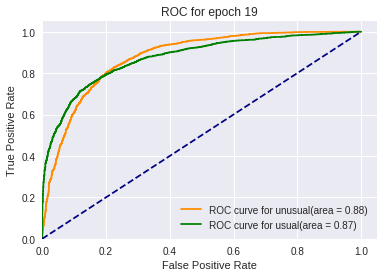

In [0]:
model_conv_img, FPR_img, TPR_img, ROC_AUC_img, THRESHOLDS_img= train_model(model_conv_img, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

In [0]:
torch.save(model_conv_img, '/content/drive/My Drive/IndependentStudy/imagenet.pth')

In [0]:
model_conv_img = torch.load('/content/drive/My Drive/IndependentStudy/imagenet.pth')

In [0]:
counter=0
confusions_img=torch.zeros(2,2)
    # Each epoch has a training and validation phase
model_conv_img.eval()   # Set model to evaluate mode
phase='val'
for inputs, labels in dataloaders[phase]:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    counter+=len(labels)
    outputs = model_conv_img(inputs)

    max_values, preds = torch.max(outputs, 1)
    for j in range(len(labels)):
        confusions_img[labels[j]][preds[j]] += 1
    loss = criterion(outputs, labels)
for ii in range(2):
    confusions_img[ii] = confusions_img[ii] / confusions_img[ii].sum()
# load best model weights

In [0]:
print(counter)
confusions_img

400


tensor([[0.6700, 0.3300],
        [0.1667, 0.8333]])

Caption Classification
===================

In [0]:
from unidecode import unidecode as unicodeToAscii

all_characters = string.printable
n_letters = len(all_characters)

print(unicodeToAscii('těší mě'))

# Read a file and split into lines
def readFile(caption_filename):
    with open(caption_filename, 'r') as f:
        data = json.load(f)
    img_names=[]
    img_captions=[]
    for img_caption, img_cat in data.items():
        img_names.append(img_cat)
        temp_caption = unicodeToAscii(img_caption)
        img_captions.append(temp_caption)
    return img_names, img_captions
#     return unicodeToAscii(data)

def get_category_data(un_file,u_file):
    un_names,img_captions_un = readFile(un_file)
    u_names,img_captions_u = readFile(u_file)
    return {'unusual':img_captions_un,'usual':img_captions_u},{'unusual':un_names,'usual':u_names},['unusual','usual']
  
def shortest_l(cap_list):
    import sys
    shortest=sys.maxsize
    for i in cap_list.values():
        for j in i:
            if len(j)<shortest:
                shortest=len(j)
    return shortest 
def longest_l(cap_list):
    longest=0
    for i in cap_list.values():
        for j in i:
            if len(j)>longest:
                longest=len(j)
    return longest 

def categoryFromOutput(output):
    top_n, top_i = output.topk(1, dim=1)
    category_i = top_i[:, 0]
    return category_i

# Turn string into long tensor
def stringToTensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

def load_random_batch(text_dict, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, 1).long().to(device)
    input_text = []
    for i in range(batch_size):
        category = all_categories[random.randint(0, len(all_categories) - 1)]
        caption_index = random.randint(0, len(text_dict[category])-1)
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
#         print(category,caption_index)
        if len(text_dict[category][caption_index])>=chunk_len:
          caption = text_dict[category][caption_index][:chunk_len]
        else:
          caption = repeatPad(text_dict[category][caption_index],chunk_len)
        input_text.append(caption)
        input_data[i] = stringToTensor(caption)
        target[i] = category_tensor
    return input_data, target, input_text
  
def repeatPad(text,length):
  if len(text)>=length:
    return text[:length]
  else:
    mult=length//len(text)+1
    text=text*mult
    return text[:length]

tesi me


In [0]:
train_data_path_un = 'all_captions_train_unusual_se_n.json'
train_data_path_u = 'all_captions_train_usual_se_n.json'
test_data_path_un = 'all_captions_test_unusual_se_n.json'
test_data_path_u = 'all_captions_test_usual_se_n.json'

train_category_data,train_category_names, all_categories = get_category_data(train_data_path_un,train_data_path_u)
test_category_data,test_category_names, test_all_categories = get_category_data(test_data_path_un,test_data_path_u)

n_classes = len(all_categories)
longest_cap_l=max(longest_l(train_category_data),longest_l(test_category_data))
print(longest_cap_l)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1, dim=1)
    category_i = top_i[:, 0]
    return category_i

# Turn string into long tensor
def stringToTensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

def load_random_batch(text_dict, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, 1).long().to(device)
    input_text = []
    for i in range(batch_size):
        category = all_categories[random.randint(0, len(all_categories) - 1)]
        caption_index = random.randint(0, len(text_dict[category])-1)
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
#         print(category,caption_index)
        if len(text_dict[category][caption_index])>=chunk_len:
          caption = text_dict[category][caption_index][:chunk_len]
        else:
          caption = repeatPad(text_dict[category][caption_index],chunk_len)
        input_text.append(caption)
        input_data[i] = stringToTensor(caption)
        target[i] = category_tensor
    return input_data, target, input_text
  
def repeatPad(text,length):
  if len(text)>=length:
    return text[:length]
  else:
    mult=length//len(text)+1
    text=text*mult
    return text[:length]

250


In [0]:
from model import RNN
chunk_len = longest_cap_l

BATCH_SIZE = 100#100
# n_epochs = 2000
hidden_size = 100
n_layers = 3#1
learning_rate = 0.01
model_type = 'gru'
weights=[2,1]#[unusual,usual]
class_weights=torch.FloatTensor(weights).cuda()
# criterion = nn.MultiMarginLoss(p=2,weight=class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()
# criterion = nn.CrossEntropyLoss()
rnn = RNN(n_letters, hidden_size, n_classes, model_type=model_type, n_layers=n_layers).to(device)

In [0]:
def train(rnn, target_tensor, data_tensor, optimizer, criterion, batch_size=BATCH_SIZE):
    """
    Inputs:
    - rnn: model
    - target_target: target character data tensor of shape (batch_size, 1)
    - data_tensor: input character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    - batch_size: data batch size
    
    Returns:
    - output: output from RNN from end of sequence 
    - loss: computed loss value as python float
    
    """
    
    output, loss = None, None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    batch_size, chunk_len = data_tensor.size()
    #You should initialize a hidden layer representation using your RNN's init_hidden function
    hidden = rnn.init_hidden(batch_size, device=device)
    # set the model gradients to zero
    rnn.zero_grad()
    # and loop over each time step (character) in the input tensor.
    for i in range(chunk_len):
        data = data_tensor[:, i].view(batch_size)
        # For each time step compute the output of the of the RNN and the next hidden layer representation.
        output, hidden = rnn(data, hidden)
    # The cross entropy loss should be computed over
    # the last RNN output scores from the end of the sequence and
    # the target classification tensor.
    loss = criterion(output.view(batch_size, -1), target_tensor.view(-1))
    #Lastly, call backward on the loss and take an optimizer step.
    loss.backward()
    optimizer.step()
    
    ##########       END      ##########

    return output, loss
    

In [0]:
def evaluate(rnn, data_tensor, seq_len=chunk_len, batch_size=BATCH_SIZE):
    with torch.no_grad():
        data_tensor = data_tensor.to(device)
        hidden = rnn.init_hidden(batch_size, device=device)
        for i in range(seq_len):
            output, hidden = rnn(data_tensor[:,i], hidden)
        
        return output
    
def eval_test(rnn, category_tensor, data_tensor):
    with torch.no_grad():
        output = evaluate(rnn, data_tensor)
        loss = criterion(output, category_tensor.squeeze())
        return output, loss.item()

In [0]:
n_iters = 200 #2000 #100000
print_every = 5
plot_every = 5


# Keep track of losses for plotting
current_loss = 0
current_test_loss = 0
all_losses = []
all_test_losses = []

start = time.time()

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


number_correct = 0
for iter in range(1, n_iters + 1):
    input_data, target_category, text_data = load_random_batch(train_category_data, chunk_len, BATCH_SIZE)
    output, loss = train(rnn, target_category, input_data, optimizer, criterion)
    current_loss += loss
    
    _, test_loss = eval_test(rnn, target_category, input_data)
    current_test_loss += test_loss
    
    guess_i = categoryFromOutput(output)
    number_correct += (target_category.squeeze()==guess_i.squeeze()).long().sum()
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        sample_idx = 0
        guess = all_categories[guess_i[sample_idx]]
        
        category = all_categories[int(target_category[sample_idx])]
        
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, test_loss, text_data[sample_idx][:50], guess, correct))
        print('Train accuracy: {}'.format(float(number_correct)/float(print_every*BATCH_SIZE)))
        number_correct = 0
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_test_losses.append(current_test_loss / plot_every)
        current_test_loss = 0

5 2% (0m 6s) 0.6750 0.6097 A person that is looking at something down the str / usual ✓
Train accuracy: 0.52
10 5% (0m 12s) 0.6613 0.6363 A couple of men standing next to each other holdin / unusual ✗ (usual)
Train accuracy: 0.492
15 7% (0m 18s) 0.6959 0.6756 a street sign is hanging on a polea street sign is / unusual ✗ (usual)
Train accuracy: 0.464
20 10% (0m 24s) 0.6689 0.6595 A computer generated woman looks from behind a com / unusual ✓
Train accuracy: 0.46
25 12% (0m 30s) 0.6277 0.5992 A blender held together by duct table holds a mixt / unusual ✓
Train accuracy: 0.484
30 15% (0m 36s) 0.6409 0.6282 A jet plane flies in the sky, covering up the sun. / unusual ✓
Train accuracy: 0.498
35 17% (0m 42s) 0.6306 0.6176 A woman running along side a horse she is showing. / unusual ✓
Train accuracy: 0.512
40 20% (0m 49s) 0.6300 0.6036 A dog wearing a vest posing for a picture.A dog we / unusual ✓
Train accuracy: 0.5
45 22% (0m 55s) 0.6683 0.6321 a cat is sitting on a couch in a rooma cat is

Plot loss functions
--------------------



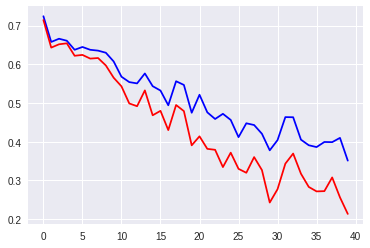

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses, color='b')
plt.plot(all_test_losses, color='r')

Evaluate results
-------------------

We now vizualize the performance of our model by creating a confusion matrix. The ground truth languages of samples are represented by rows in the matrix while the predicted languages are represented by columns.

In this evaluation we consider sequences of variable sizes rather than the fixed length sequences we used for training.

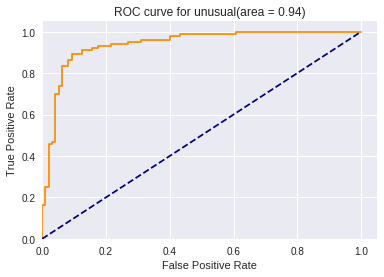

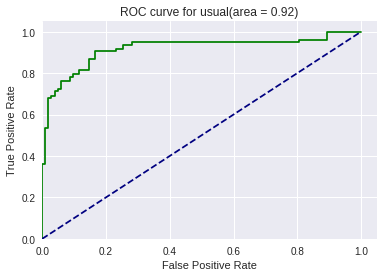

Test accuracy:  0.84
tensor([[0.9515, 0.0485],
        [0.2784, 0.7216]])


NameError: ignored

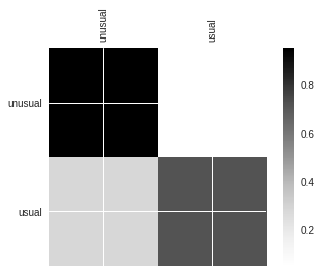

In [0]:
eval_batch_size = 1  # needs to be set to 1 for evaluating different sequence lengths

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_classes, n_classes)
n_confusion = 200#1000
num_correct = 0
total = 0
gt1=[]
gt0=[]
guess=[]
score={'0':[],'1':[]}
for i in range(n_confusion):
    eval_chunk_len = longest_cap_l#random.randint(10, 50) # in evaluation we will look at sequences of variable sizes
    input_data, target_category, text_data = load_random_batch(test_category_data, chunk_len=eval_chunk_len, batch_size=eval_batch_size)
    output = evaluate(rnn, input_data, seq_len=eval_chunk_len, batch_size=eval_batch_size)
    
    guess_i = categoryFromOutput(output)
    category_i = [int(target_category[idx]) for idx in range(len(target_category))]
    for j in range(eval_batch_size):
        category = all_categories[category_i[j]] 
        confusion[category_i[j]][guess_i[j]] += 1
        num_correct += int(guess_i[j]==category_i[j])
        total += 1
        ##############roc############
        gt0.append(1-category_i[j]) 
        gt1.append(category_i[j])
        guess.append(guess_i[j])
        out_v=output
        out_v0=out_v[:,0][j]
        out_v1=out_v[:,1][j]
        score['0'].append(out_v0.cpu())
        score['1'].append(out_v1.cpu())
from sklearn import metrics
fpr0, tpr0, thresholds0 = metrics.roc_curve(gt0, score['0'])
roc_auc0 = metrics.auc(fpr0, tpr0)
fig=plt.figure()
plt.plot(fpr0, tpr0, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for unusual(area = %0.2f)' % roc_auc0)
# plt.legend(loc="lower right")
plt.show()
fpr1, tpr1, thresholds1 = metrics.roc_curve(gt1, score['1'])
roc_auc1 = metrics.auc(fpr1, tpr1)
fig2=plt.figure()
plt.plot(fpr1, tpr1, color='green')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for usual(area = %0.2f)' % roc_auc1)
# plt.legend(loc="lower right")
plt.show()
print('Test accuracy: ', float(num_correct)/float(n_confusion*eval_batch_size))

# Normalize by dividing every row by its sum
for i in range(n_classes):
    confusion[i] = confusion[i] / confusion[i].sum()
print(confusion)
# Set up plot
fig3 = plt.figure()
ax = fig3.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig3.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [0]:
torch.save(rnn, '/content/drive/My Drive/IndependentStudy/textnet.pth')

In [0]:
rnn = torch.load('/content/drive/My Drive/IndependentStudy/textnet.pth')

Combined Prediction
====================

In [0]:
class ImageFolderX(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        return super(ImageFolderX, self).__getitem__(index), self.imgs[index][0]#return image path

# EXAMPLE USAGE:
# instantiate the dataset and dataloader
c_test_dataset =ImageFolderX(os.path.join(data_dir, 'val'),
                                          data_transforms['val']) # our custom dataset
c_eval_batch_size = 1  # needs to be set to 1 for evaluating different sequence lengths
c_test_dataloader = torch.utils.data.DataLoader(c_test_dataset, batch_size=c_eval_batch_size,
                                              num_workers=0)

NameError: ignored

In [0]:
def sigmoid(a):
    return 1/(1+torch.exp(-a))


def load_certain_batch(text_dict,cap_index, label,all_categories,batch_size=1):
    
    target = torch.zeros(batch_size, 1).long().to(device)
    input_text = []
    for i in range(batch_size):
        category = all_categories[label]
        caption_index = cap_index[random.randint(0, len(cap_index)-1)]
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        caption = text_dict[category][caption_index]
        input_text.append(caption)
        input_data = stringToTensor(caption).to(device)
        target[i] = category_tensor
    input_data=input_data.view(batch_size,-1)
    return input_data, target, input_text

In [0]:
# Keep track of correct guesses in a confusion matrix
c_confusion = torch.zeros(n_classes, n_classes)
c_n_confusion = 400#1000
c_num_correct = 0
c_total = 0
c_gt1=[]
c_gt0=[]
c_guess=[]
c_label=[]
c_score={'0':[],'1':[]}
sig_all=torch.zeros(c_n_confusion,2)
# for i in range(c_n_confusion):
    
model_conv_img.eval()
rnn.eval()
ii=0
for (inputs, labels), address in c_test_dataloader:
    
#     print('iter',ii)
    inputs = inputs.to(device)
    labels = labels.to(device)
    c_label.append(int(labelsmat[:100,2]))
    # zero the parameter gradients

    # forward
    # track history if only in train
#         with torch.set_grad_enabled(phase == 'train'):
    with torch.no_grad():
        outputs_i = model_conv_img(inputs)
    sig_i= sigmoid(outputs_i)

#         max_values, preds_i = torch.max(outputs_i, 1)
#         loss = criterion(outputs, labels)
    sig_t=None
    for j, image_name in enumerate(address):
        image_name=image_name[-16:]
        cap_index=list(np.where(np.array(test_category_names[all_categories[int(labels[j])]])==image_name)[0])
        label=labels[j]
        input_data_t,target_t,input_text_t = load_certain_batch(test_category_data,cap_index,int(label),all_categories)
        output_t = evaluate(rnn, input_data_t, seq_len=len(input_data_t), batch_size=c_eval_batch_size)
        sig_t= sigmoid(output_t)
        c_total+=1
    sig_c=sig_i+sig_t
    max_values, preds_c = torch.max(sig_c,1)
    c_num_correct += int(int(preds_c)==int(labels))
    c_confusion[int(labels)][int(preds_c)]+=1
    sig_all[ii]=sig_c
    c_guess.append(int(preds_c))
    c_gt0.append(1-int(labels)) 
    c_gt1.append(int(labels))
    out_v0=sig_c[:,0]
    out_v1=sig_c[:,1]
    c_score['0'].append(out_v0.cpu())
    c_score['1'].append(out_v1.cpu())
    ii+=1

#     epoch_loss = running_loss / dataset_sizes[phase]
#     epoch_acc = running_corrects.double() / dataset_sizes[phase]

#     print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


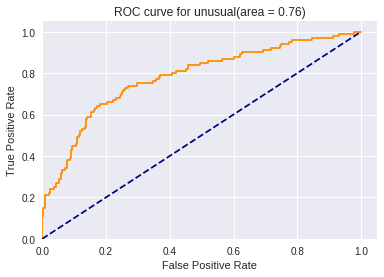

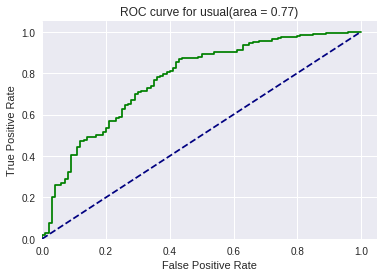

Test accuracy:  0.7
tensor([[0.5800, 0.4200],
        [0.1533, 0.8467]])


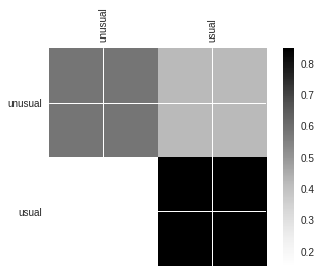

In [0]:
from sklearn import metrics
c_fpr0, c_tpr0, c_thresholds0 = metrics.roc_curve(c_gt0, c_score['0'])
c_roc_auc0 = metrics.auc(c_fpr0, c_tpr0)
fig=plt.figure()
plt.plot(c_fpr0, c_tpr0, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for unusual(area = %0.2f)' % roc_auc0)
# plt.legend(loc="lower right")
plt.show()
c_fpr1, c_tpr1, c_thresholds1 = metrics.roc_curve(c_gt1, c_score['1'])
c_roc_auc1 = metrics.auc(c_fpr1, c_tpr1)
fig2=plt.figure()
plt.plot(c_fpr1, c_tpr1, color='green')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for usual(area = %0.2f)' % roc_auc1)
# plt.legend(loc="lower right")
plt.show()
print('Test accuracy: ', float(num_correct)/float(n_confusion*eval_batch_size))

# Normalize by dividing every row by its sum
for i in range(n_classes):
    c_confusion[i] = c_confusion[i] / c_confusion[i].sum()
print(c_confusion)
# Set up plot
fig3 = plt.figure()
ax = fig3.add_subplot(111)
cax = ax.matshow(c_confusion.numpy())
fig3.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show() 

In [0]:
# a=sig_all[1:10]
# c=np.resize(np.array(c_guess[1:10]),(len(c_guess[1:10]),1))
# a=a.numpy()
# print(a,c)
# print(a.shape,c.shape)
# cat_test=np.concatenate((a,c),axis=1)
# print(cat_test)
# mat = cat_test[cat_test[:,0].argsort()[::-1]]
# print(mat)

sig_all_np=sig_all.numpy()
c_label_np=np.resize(np.array(c_label),(len(c_label),1))
cat_all=np.concatenate((sig_all_np,c_label_np),axis=1)
mat=cat_all[cat_all[:,0].argsort()[::-1]]
sum(mat[:100,2])

42.0